## Introduction

In this notebook, we plot the perturbative short-time propagator for a given
drift and diffusivity profile.

We use the normalization-preserving propagator Eq. (23) from 
"Short-time Fokker-Planck propagator beyond the Gaussian approximation" (arXiv: http://arxiv.org/abs/2405.18381), which in the following
we refer to as Ref. [1].

The positivity-preserving propagator can be used by setting ''positivity_preserving'' 
to true where it appears below.

We show two ways of defining a lambda function $P(x,t)$ for the propagator:

1. By providing PySTFP with symbolic expressions for drift $a$ and diffusivity $D$

2. By providing PySTFP with numpy arrays that contain the derivatives of drift and diffusivity at $x_0$

We demonstrate that these two lead to the same propagator.

In [1]:
import sympy as sp
from PySTFP import PySTFP
import matplotlib.pyplot as plt
import numpy as np

In [2]:
p = PySTFP() # create instance of PySTFP

## Define drift and diffusivity, and plot them

In [3]:
x = p.x
L = p.L # length scale
T = p.T # time scale
D0 = L**2 / T # diffusivity scale

# Define diffusivity profile
D = D0 * (1 + 0.2*sp.cos(x/L))

# Define drift profile
a = L/T * ( -3*(x/L) + 2*(x/L)**3 )

# Define starting point 
x0 = 0.5*L

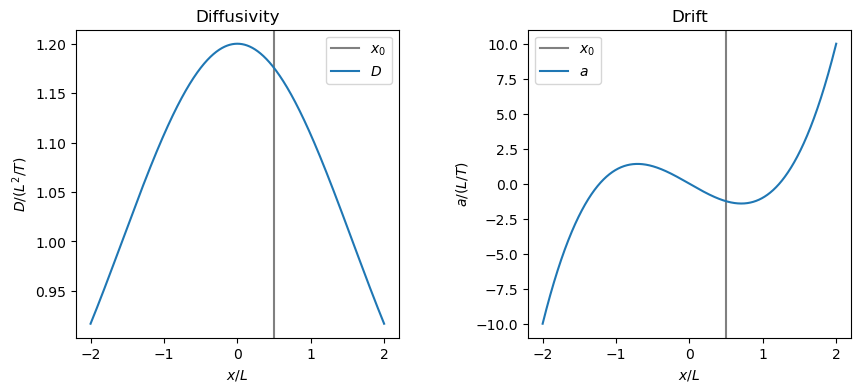

In [4]:
# plot diffusivity and drift
D_lambda = sp.lambdify(x, 
                sp.expand((D/D0).subs(x,x*L))
                )
a_lambda = sp.lambdify(x, 
                sp.expand((a/(L/T)).subs(x,x*L))
                )

fig, axes = plt.subplots(1,2,figsize=(10,4))
fig.subplots_adjust(wspace=0.4)

xP = np.linspace(-2,2,num=2001)





for i in range(2):
    axes[i].axvline(x0/L,color='gray',
                    label=r'$x_0$')
    #
    axes[i].set_xlabel(r'$x/L$')
    #
    if i == 0:
        axes[i].plot(xP,D_lambda(xP),
                        label=r'$D$')
        axes[i].set_ylabel(r'$D/(L^2/T)$')
        axes[i].set_title(r'Diffusivity')
    else:
        axes[i].plot(xP,a_lambda(xP),
                        label=r'$a$')
        axes[i].set_ylabel(r'$a/(L/T)$')
        axes[i].set_title(r'Drift')
    axes[i].legend(loc='best')

plt.show()
plt.close(fig)

## Evaluate propagator via symbolic diffusivity- and drift profiles

In [5]:
p.set_a(a=a)
p.set_D(D=D)
p.set_x0(x0=x0)

In [6]:
order = 5 # order in perturbation theory

In [7]:
P = p.get_probability_density(order=order,
                        positivity_preserving=False, # this is the default
                            )

In [8]:
# time at which we evaluate the propagator
t = 0.01 # in units of T

In [9]:
# spatial plotting range
R = np.sqrt(5*t)
xlims = [float(x0/L) - R, float(x0/L) + R]
xP = np.linspace(xlims[0],xlims[1],
                    num=2001)

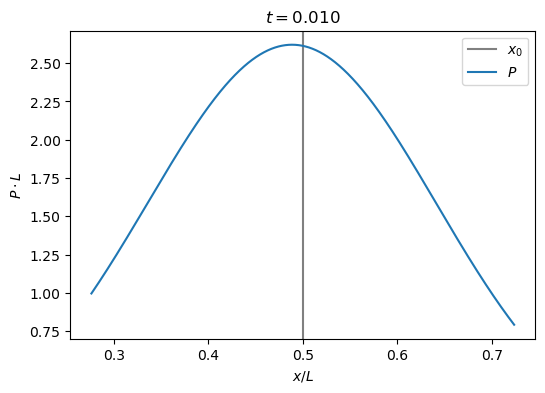

In [10]:
# evaluate propagator
P_eval = P(xP,t)

# plot
fig, ax = plt.subplots(1,1,figsize=(6,4))
ax.axvline(x0/L,color='gray',
                    label=r'$x_0$')
ax.plot(xP,P_eval,label=r'$P$')

ax.set_xlabel(r'$x/L$')
ax.set_ylabel(r'$P \cdot L$')
ax.set_title(r'$t = {0:3.3f}$'.format(t))
ax.legend(loc='best')

plt.show()
plt.close(fig)

## Evaluate propagator from pre-calculated derivatives of $a$, $D$ at $x_0$

In [11]:
# First we calculate the derivatives from our symbolic definitions of a, D

a_x0 = []

current_derivative = a
a_x0.append( float( current_derivative.subs(x,x0)/(L/T) ) )
for i in range(order):
    current_derivative = sp.diff(current_derivative,x,1)
    a_x0.append( float( current_derivative.subs(x,x0)/(L/T)*L**(i+1) ) )


D_x0 = []

current_derivative = D
D_x0.append( float( current_derivative.subs(x,x0)/D0 ) )
for i in range(order):
    current_derivative = sp.diff(current_derivative,x,1)
    D_x0.append( float( current_derivative.subs(x,x0)/D0*L**(i+1) ) )

In [12]:
a_x0 # a_x0[n] = n-th derivative of a at x0

[-1.25, -1.5, 6.0, 12.0, 0.0, 0.0]

In [13]:
D_x0 # D_x0[n] = n-th derivative of D at x0

[1.1755165123780746,
 -0.0958851077208406,
 -0.17551651237807456,
 0.0958851077208406,
 0.17551651237807456,
 -0.0958851077208406]

In [14]:
P = p.get_probability_density_from_derivatives(D_derivatives=D_x0,
                            a_derivatives=a_x0,
                            order=order,
                            x0 = float(x0/L),
                            positivity_preserving=False, # this is the default
                    )

## Of course, both ways of calculating the perturbative propagator give the same result:

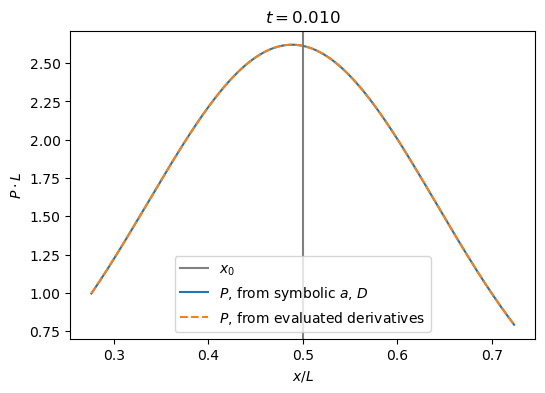

In [15]:
# evaluate propagator
P_eval_derivatives = P(xP,t)

# plot
fig, ax = plt.subplots(1,1,figsize=(6,4))
ax.axvline(x0/L,color='gray',
                    label=r'$x_0$')
ax.plot(xP,P_eval,label=r'$P$, from symbolic $a$, $D$')
ax.plot(xP,P_eval_derivatives,
                label=r'$P$, from evaluated derivatives',
                ls='--')

ax.set_xlabel(r'$x/L$')
ax.set_ylabel(r'$P \cdot L$')
ax.set_title(r'$t = {0:3.3f}$'.format(t))
ax.legend(loc='best')

plt.show()
plt.close(fig)